# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [36]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import scipy
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [37]:
# using SQLite Table to read data.
con = sqlite3.connect('C:\\Users\\TUSHAR\\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [38]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [39]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [40]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [41]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [42]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [43]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [44]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [45]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [46]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [47]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [48]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [49]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more g

In [50]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [51]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and"ko-"  is "child of" or of "derived from".) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.
What can I say..

In [52]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [53]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.


In [54]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [55]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb pan bread a Portuguese loan word and quot ko quot is quot child of quot or of quot derived from quot Panko are used for katsudon tonkatsu or cutlets served on rice or in soups The cutlets pounded chicken or pork are coated with these light and crispy crumbs and fried They are not gritty and dense like regular crumbs They are very nice on deep fried shrimps and decorative for a more gourmet touch 


In [56]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [57]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 160176/160176 [01:04<00:00, 2465.25it/s]


In [58]:
preprocessed_reviews[1500]

'japanese version breadcrumb pan bread portuguese loan word ko child derived panko used katsudon tonkatsu cutlets served rice soups cutlets pounded chicken pork coated light crispy crumbs fried not gritty dense like regular crumbs nice deep fried shrimps decorative gourmet touch'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [59]:
final["preprocessed_reviews"]=preprocessed_reviews

final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_reviews
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,1,1325721600,A classic,I remembered this book from my childhood and g...,remembered book childhood got kids good rememb...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138686,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,entertaining rhyming story cleaver catchy illu...
138685,150503,0006641040,A3R5XMPFU8YZ4D,"Her Royal Motherliness ""Nana""",1,1,1,1233964800,so fun to read,This is my grand daughter's and my favorite bo...,grand daughter favorite book read loves rhythm...


In [60]:
X=final["preprocessed_reviews"]
y=final["Score"]
#train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=0) 
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting

# [4] Featurization

## [4.1] BAG OF WORDS

In [158]:
#BoW
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10) #in scikit-learn
X_train_bow=count_vect.fit_transform(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow=count_vect.transform(X_test)

print("After vectorization:")
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of train text BOW vectorizer ",X_train_bow.shape,y_train.shape)
print("the shape of CV text BOW vectorizer ",X_cv_bow.shape,y_cv.shape)
print("the shape of test text BOW vectorizer ",X_test_bow.shape,y_test.shape)
print("the number of unique words ", X_train_bow.get_shape()[1])

some feature names  ['aa', 'aback', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink']
After vectorization:
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train text BOW vectorizer  (71902, 41725) (71902,)
the shape of CV text BOW vectorizer  (35415, 41725) (35415,)
the shape of test text BOW vectorizer  (52859, 41725) (52859,)
the number of unique words  41725


In [159]:
X_train_bow.shape

(71902, 41725)

In [160]:
#Applying multinomial naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [161]:
model_bow=MultinomialNB()
parameters={'alpha':[0.0001,0.001,0.01,0.1,1,10^1,10^2,10^3,10^4]}

clf=GridSearchCV(model_bow,parameters,cv=10,scoring='roc_auc',n_jobs=-1)

clf.fit(X_train_bow,y_train)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

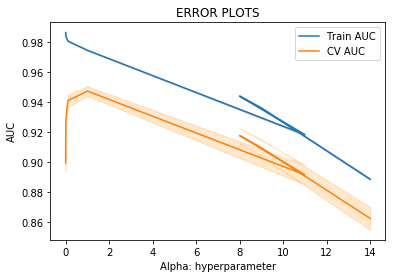

In [162]:
alpha=[0.0001,0.001,0.01,0.1,1,10^1,10^2,10^3,10^4]
plt.plot(alpha, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [163]:
# from the error plot we choose alpha such that, we will have maximum AUC on cv data and gap between the train and cv is less
#we are taking 1.2 as our alpha value
best_alpha=1.2

In [164]:
from sklearn.metrics import roc_curve, auc

model_nb=MultinomialNB(alpha=1.2)

model_nb.fit(X_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, model_nb.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model_nb.predict_proba(X_test_bow)[:,1])

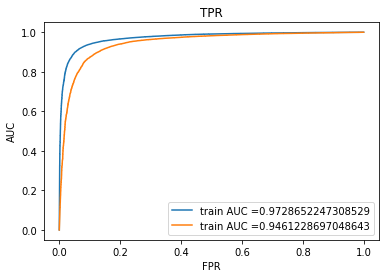

Train confusion matrix
[[10097  1258]
 [ 3345 57202]]
Test confusion matrix
[[ 6766  1598]
 [ 2789 41706]]


In [165]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("AUC")
plt.title("TPR")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model_nb.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model_nb.predict(X_test_bow)))

In [166]:
log_prob=model_nb.feature_log_prob_

In [167]:
feature_names=count_vect.get_feature_names()

In [168]:
log_prob.shape

(2, 41725)

In [169]:
feature_prob = pd.DataFrame(log_prob, columns = feature_names)

In [170]:
feature_prob=feature_prob.T

In [171]:
feature_prob.head()

,0,1
aa,-11.612064,-12.542729
aback,-13.254292,-12.457206
abandoned,-11.462532,-12.636255
abdominal,-11.217410,-12.854508
ability,-11.217410,-10.599373


In [172]:
print("Top 10 negative words are :\n",feature_prob[0].sort_values(ascending=False)[:10])
print("="*50)
print("Top 10 positive words are :\n",feature_prob[1].sort_values(ascending=False)[:10])

Top 10 negative words are :
 not       -3.606008
like      -4.728436
would     -4.958951
product   -4.993024
taste     -5.012369
one       -5.205717
coffee    -5.356624
good      -5.480417
no        -5.508135
flavor    -5.528520
Name: 0, dtype: float64
Top 10 positive words are :
 not      -4.023231
like     -4.847239
good     -4.974718
great    -5.044304
one      -5.180253
taste    -5.271869
coffee   -5.276537
flavor   -5.365751
love     -5.375346
would    -5.385313
Name: 1, dtype: float64


Text(33,0.5,'Actual Class')

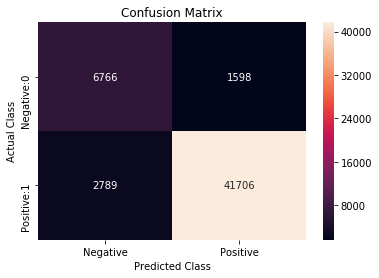

In [173]:
import seaborn as sns
confusion_matrix_test_BOW = confusion_matrix(y_test, model_nb.predict(X_test_bow))

df_cm=pd.DataFrame(confusion_matrix_test_BOW,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [174]:
#let do some feature engineerng on top of BOW and see if performance increased or not

#Taking length of reviews as another feature
#Added 2 columns extra :
#1st is total length of each preprocessed review 
#2nd is length of each preprocessed review by word

In [175]:
final["length of preprocessed_reviews"]=pd.Series(final["preprocessed_reviews"].str.len())
final["length of preprocessed_reviews_bywords"]=pd.Series(final["preprocessed_reviews"].str.split().str.len())

In [176]:
X=final.drop(["Id","ProductId","UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Score","Time","Summary"],axis=1)

In [177]:
X=X.drop(["Text"],axis=1)
y=final["Score"]

In [178]:
X.head()

,preprocessed_reviews,length of preprocessed_reviews,length of preprocessed_reviews_bywords
138695,remembered book childhood got kids good rememb...,114,17
138707,daughter loves really rosie books introduced r...,285,44
138708,one best children books ever written mini vers...,144,22
138686,entertaining rhyming story cleaver catchy illu...,142,18
138685,grand daughter favorite book read loves rhythm...,80,12


In [179]:
X_train_FT, X_test_FT, y_train_FT, y_test_FT = train_test_split(X, y, test_size=0.33,random_state=0) 
X_train_FT, X_cv_FT, y_train_FT, y_cv_FT = train_test_split(X_train_FT, y_train_FT, test_size=0.33) # this is random splitting

In [180]:
X_train_FT.shape

(71902, 3)

In [181]:
X_train_FT.head()

,preprocessed_reviews,length of preprocessed_reviews,length of preprocessed_reviews_bywords
114945,love penne ala vodka love making sauce oz jars...,93,16
17849,pear infusion not knock head subtle soothing t...,113,17
87727,even called yakisoba real yakisoba not not tas...,119,20
30763,agree reviewers find k cups lacking strength f...,130,20
193317,great container dog likes likes soft treats wa...,100,16


In [182]:
X_train_length_of_reviews=X_train_FT.drop("preprocessed_reviews",axis=1)

In [183]:
X_train_length_of_reviews.shape

(71902, 2)

In [184]:
X_train_bow.shape

(71902, 41725)

In [185]:
type(X_train_length_of_reviews)

pandas.core.frame.DataFrame

In [186]:
X_train_length_of_reviews=np.array(X_train_length_of_reviews)

In [187]:
X_train_length_of_reviews.shape

(71902, 2)

In [188]:
X_train_bow=scipy.sparse.hstack((X_train_bow,X_train_length_of_reviews)) #https://stackoverflow.com/questions/19710602/concatenate-sparse-matrices-in-python-using-scipy-numpy

In [189]:
X_train_bow.shape

(71902, 41727)

In [190]:
X_test_length_of_reviews = X_test_FT.drop("preprocessed_reviews",axis=1)

In [191]:
X_test_length_of_reviews.shape

(52859, 2)

In [192]:
X_test_bow.shape

(52859, 41725)

In [193]:
X_test_bow=scipy.sparse.hstack((X_test_bow,X_test_length_of_reviews)) #https://stackoverflow.com/questions/19710602/concatenate-sparse-matrices-in-python-using-scipy-numpy

In [194]:
model_bow=MultinomialNB()
parameters={'alpha':[0.0001,0.001,0.01,0.1,1,10^1,10^2,10^3,10^4]}

clf_bow=GridSearchCV(model_bow,parameters,cv=10,scoring='roc_auc',n_jobs=-1)

clf_bow.fit(X_train_bow,y_train_FT)
train_auc_bow= clf_bow.cv_results_['mean_train_score']
train_auc_std_bow= clf_bow.cv_results_['std_train_score']
cv_auc_bow = clf_bow.cv_results_['mean_test_score'] 
cv_auc_std_bow= clf_bow.cv_results_['std_test_score']

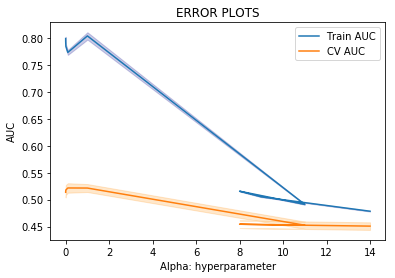

In [195]:
alpha=[0.0001,0.001,0.01,0.1,1,10^1,10^2,10^3,10^4]
plt.plot(alpha, train_auc_bow, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha,train_auc_bow - train_auc_std_bow,train_auc_bow + train_auc_std_bow,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_auc_bow, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha,cv_auc_bow - cv_auc_std_bow,cv_auc_bow + cv_auc_std_bow,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [196]:
#from above its shown that we are getting best alpha at 2
#lets build model with alpha=2

In [197]:
from sklearn.metrics import roc_curve, auc

model_nb=MultinomialNB(alpha=2)

model_nb.fit(X_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train_FT, model_nb.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_FT, model_nb.predict_proba(X_test_bow)[:,1])

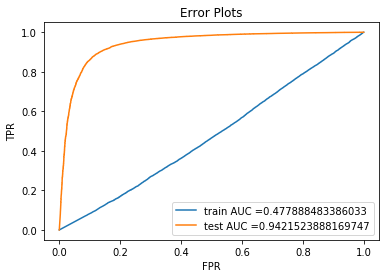

Train confusion matrix
[[ 2085  9310]
 [11677 48830]]
Test confusion matrix
[[ 6395  1969]
 [ 2141 42354]]


In [198]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Error Plots")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train_FT, model_nb.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test_FT, model_nb.predict(X_test_bow)))

Heatmap for test confusion matrix


Text(33,0.5,'Actual Class')

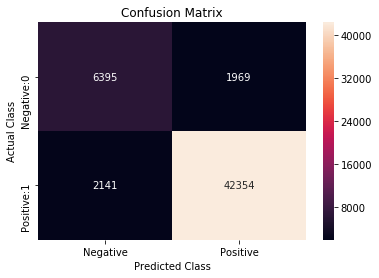

In [199]:
import seaborn as sns
print("Heatmap for test confusion matrix")
confusion_matrix_test_BOW = confusion_matrix(y_test_FT, model_nb.predict(X_test_bow))

df_cm=pd.DataFrame(confusion_matrix_test_BOW,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [200]:
#we can see that after length of each reviews model is performing worst than without adding length of each reviews.
#hence we cant proceed with this model

## [4.3] TF-IDF

In [61]:
X=final["preprocessed_reviews"]
y=final["Score"]
#train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=0) 
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting

In [62]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tf_idf = tf_idf_vect.transform(X_train)
X_cv_tf_idf = tf_idf_vect.transform(X_cv)
X_test_tf_idf = tf_idf_vect.transform(X_test)
print("After Vectorization:\n")
print("the type of count vectorizer ",type(X_train_tf_idf))
print("the shape of train text TFIDF vectorizer :",X_train_tf_idf.get_shape(),y_train.shape)
print("the shape of CV text TFIDF vectorizer :",X_cv_tf_idf.get_shape(),y_cv.shape)
print("the shape of test text TFIDF vectorizer :",X_test_tf_idf.get_shape(),y_test.shape)
print("the number of unique words including both unigrams and bigrams ", X_train_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aback', 'abandoned', 'abdominal', 'ability', 'able', 'able buy', 'able chew', 'able cut', 'able drink']
After Vectorization:

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train text TFIDF vectorizer : (71902, 42031) (71902,)
the shape of CV text TFIDF vectorizer : (35415, 42031) (35415,)
the shape of test text TFIDF vectorizer : (52859, 42031) (52859,)
the number of unique words including both unigrams and bigrams  42031


In [63]:
#Applying multinomial naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [64]:
model_tfidf=MultinomialNB()
parameters={'alpha':[0.0001,0.001,0.01,0.1,1,10^1,10^2,10^3,10^4]}

clf_tfidf=GridSearchCV(model_tfidf,parameters,cv=10,scoring='roc_auc',n_jobs=-1)

clf_tfidf.fit(X_train_tf_idf,y_train)
train_auc_tfidf= clf_tfidf.cv_results_['mean_train_score']
train_auc_std_tfidf= clf_tfidf.cv_results_['std_train_score']
cv_auc_tfidf = clf_tfidf.cv_results_['mean_test_score'] 
cv_auc_std_tfidf= clf_tfidf.cv_results_['std_test_score']

In [66]:
clf_tfidf.best_estimator_

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

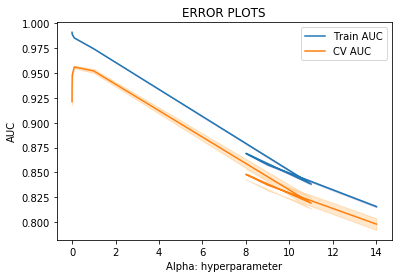

In [65]:
alpha=[0.0001,0.001,0.01,0.1,1,10^1,10^2,10^3,10^4]
plt.plot(alpha, train_auc_tfidf, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha,train_auc_tfidf - train_auc_std_tfidf,train_auc_tfidf + train_auc_std_tfidf,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_auc_tfidf, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha,cv_auc_tfidf - cv_auc_std_tfidf,cv_auc_tfidf + cv_auc_std_tfidf,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [67]:
# from the error plot we choose alpha such that, we will have maximum AUC on cv data and gap between the train and cv is less
#we are taking 1.3 as our alpha value
best_alpha=0.1

In [68]:
from sklearn.metrics import roc_curve, auc

model_nb=MultinomialNB(best_alpha)

model_nb.fit(X_train_tf_idf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, model_nb.predict_proba(X_train_tf_idf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model_nb.predict_proba(X_test_tf_idf)[:,1])

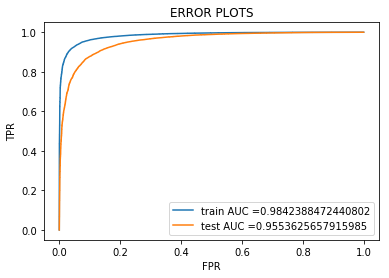

Train confusion matrix
[[ 7621  3792]
 [  526 59963]]
Test confusion matrix
[[ 4174  4190]
 [  497 43998]]


In [69]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model_nb.predict(X_train_tf_idf)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, model_nb.predict(X_test_tf_idf)))

In [70]:
log_prob=model_nb.feature_log_prob_
feature_names=tf_idf_vect.get_feature_names()

In [71]:
feature_prob = pd.DataFrame(log_prob, columns = feature_names)
feature_prob_tfidf=feature_prob.T

In [72]:
feature_prob_tfidf.head()

,0,1
aa,-10.881495,-11.948315
aback,-12.120386,-12.172332
abandoned,-11.356437,-12.887355
abdominal,-11.135183,-12.523122
ability,-10.777891,-10.211625


In [73]:
print("Top 10 negative words are :\n",feature_prob_tfidf[0].sort_values(ascending=False)[:10])
print("="*50)
print("Top 10 positive words are :\n",feature_prob_tfidf[1].sort_values(ascending=False)[:10])

Top 10 negative words are :
 not       -4.783548
like      -5.606874
product   -5.699769
taste     -5.716130
would     -5.734078
coffee    -5.943748
one       -6.039920
no        -6.161565
flavor    -6.182274
good      -6.273874
Name: 0, dtype: float64
Top 10 positive words are :
 not       -5.328573
great     -5.677908
good      -5.746730
like      -5.803746
coffee    -5.813786
love      -5.910575
tea       -5.920103
product   -6.021630
one       -6.024101
taste     -6.040580
Name: 1, dtype: float64


Heatmap for train confusion matrix


Text(33,0.5,'Actual Class')

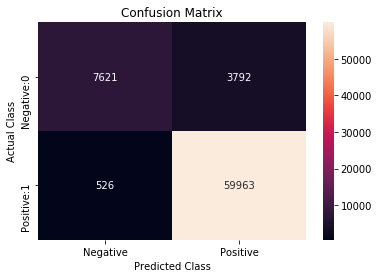

In [74]:
import seaborn as sns
print("Heatmap for train confusion matrix")
confusion_matrix_train_tfidf = confusion_matrix(y_train, model_nb.predict(X_train_tf_idf))

df_cm=pd.DataFrame(confusion_matrix_train_tfidf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap for test confusion matrix


Text(33,0.5,'Actual Class')

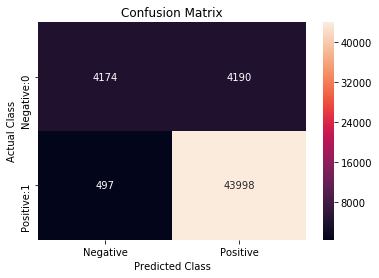

In [75]:
import seaborn as sns
print("Heatmap for test confusion matrix")
confusion_matrix_test_tfidf = confusion_matrix(y_test, model_nb.predict(X_test_tf_idf))

df_cm=pd.DataFrame(confusion_matrix_test_tfidf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [76]:
#let do some feature engineerng on top of TFIDF and see if performance increased or not

#Taking length of reviews as another feature
#Added 2 columns extra :
#1st is total length of each preprocessed review 
#2nd is length of each preprocessed review by word

In [77]:
final["length of preprocessed_reviews"]=pd.Series(final["preprocessed_reviews"].str.len())
final["length of preprocessed_reviews_bywords"]=pd.Series(final["preprocessed_reviews"].str.split().str.len())

In [78]:
X=final.drop(["Id","ProductId","UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Score","Time","Summary"],axis=1)

In [79]:
X=X.drop(["Text"],axis=1)
y=final["Score"]

In [80]:
X.head()

,preprocessed_reviews,length of preprocessed_reviews,length of preprocessed_reviews_bywords
138695,remembered book childhood got kids good rememb...,114,17
138707,daughter loves really rosie books introduced r...,285,44
138708,one best children books ever written mini vers...,144,22
138686,entertaining rhyming story cleaver catchy illu...,142,18
138685,grand daughter favorite book read loves rhythm...,80,12


In [81]:
X_train_FT, X_test_FT, y_train_FT, y_test_FT = train_test_split(X, y, test_size=0.33,random_state=0) 
X_train_FT, X_cv_FT, y_train_FT, y_cv_FT = train_test_split(X_train_FT, y_train_FT, test_size=0.33) # this is random splitting

In [82]:
X_train_length_of_reviews_1=X_train_FT.drop("preprocessed_reviews",axis=1)

In [83]:
X_test_length_of_reviews_1=X_test_FT.drop("preprocessed_reviews",axis=1)

In [84]:
X_test_length_of_reviews_1.shape

(52859, 2)

In [85]:
X_train_tf_idf_1=scipy.sparse.hstack((X_train_tf_idf,X_train_length_of_reviews_1)) #https://stackoverflow.com/questions/19710602/concatenate-sparse-matrices-in-python-using-scipy-numpy

In [86]:
X_train_tf_idf_1.shape

(71902, 42033)

In [87]:
X_test_tf_idf_1=scipy.sparse.hstack((X_test_tf_idf,X_test_length_of_reviews_1)) #https://stackoverflow.com/questions/19710602/concatenate-sparse-matrices-in-python-using-scipy-numpy

In [88]:
X_test_tf_idf_1.shape

(52859, 42033)

In [89]:
model_tfidf=MultinomialNB()
parameters={'alpha':[0.0001,0.001,0.01,0.1,1,10^1,10^2,10^3,10^4]}

clf_tfidf=GridSearchCV(model_tfidf,parameters,cv=10,scoring='roc_auc',n_jobs=-1)

clf_tfidf.fit(X_train_tf_idf_1,y_train_FT)
train_auc_tfidf= clf_tfidf.cv_results_['mean_train_score']
train_auc_std_tfidf= clf_tfidf.cv_results_['std_train_score']
cv_auc_tfidf = clf_tfidf.cv_results_['mean_test_score'] 
cv_auc_std_tfidf= clf_tfidf.cv_results_['std_test_score']

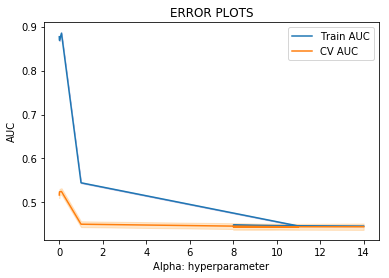

In [90]:
alpha=[0.0001,0.001,0.01,0.1,1,10^1,10^2,10^3,10^4]
plt.plot(alpha, train_auc_tfidf, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha,train_auc_tfidf - train_auc_std_tfidf,train_auc_tfidf + train_auc_std_tfidf,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_auc_tfidf, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(alpha,cv_auc_tfidf - cv_auc_std_tfidf,cv_auc_tfidf + cv_auc_std_tfidf,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [91]:
clf_tfidf.best_estimator_

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [92]:
#lets take best alpha = 0.1

In [93]:
y_test_FT.shape

(52859,)

In [95]:
model_nb=MultinomialNB(alpha=0.1)

model_nb.fit(X_train_tf_idf_1,y_train_FT)
train_fpr, train_tpr, thresholds = roc_curve(y_train_FT, model_nb.predict_proba(X_train_tf_idf_1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_FT, model_nb.predict_proba(X_test_tf_idf_1)[:,1])



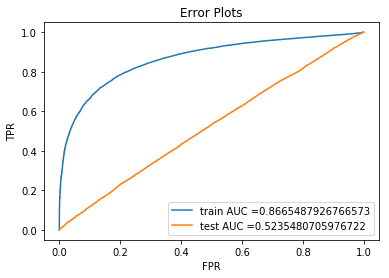

Train confusion matrix
[[  416 10947]
 [  444 60095]]
Test confusion matrix
[[   53  8311]
 [  167 44328]]


In [96]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Error Plots")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train_FT, model_nb.predict(X_train_tf_idf_1)))
print("Test confusion matrix")
print(confusion_matrix(y_test_FT, model_nb.predict(X_test_tf_idf_1)))

Heatmap for test confusion matrix


Text(33,0.5,'Actual Class')

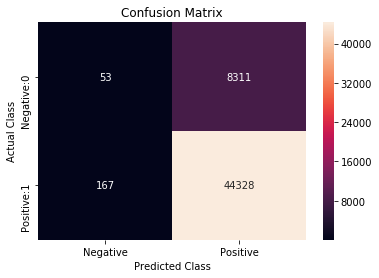

In [97]:
print("Heatmap for test confusion matrix")
confusion_matriX_test_tf_idf = confusion_matrix(y_test_FT, model_nb.predict(X_test_tf_idf_1))

df_cm=pd.DataFrame(confusion_matriX_test_tf_idf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [98]:
##we can see that after length of each reviews model is performing worst than without adding length of each reviews.
#hence we cant proceed with this model

## Conclusion

In [99]:
from prettytable import PrettyTable
X=PrettyTable()
X.field_names=["Model_Name","Train_Accuracy","Test_Acuracy","Optimal_Alpha"]
X.add_row(["Naive Bayes With BOW", 97.2, 94.6, 1.2])
X.add_row(["Naive Bayes With TFIDF", 97.9, 95.3, 1.3])
print(X)

+------------------------+----------------+--------------+---------------+
|       Model_Name       | Train_Accuracy | Test_Acuracy | Optimal_Alpha |
+------------------------+----------------+--------------+---------------+
|  Naive Bayes With BOW  |      97.2      |     94.6     |      1.2      |
| Naive Bayes With TFIDF |      97.9      |     95.3     |      1.3      |
+------------------------+----------------+--------------+---------------+


### Observation

In [100]:
#naive bayes with tfidf performs slightly better than naive bayes with BOW on test data
#also after adding length of each reviews as feature engineering feature both models performing worse than without adding 
#length of reviews.